# Data Science Challenge

__Context__

A company wants to know the CTR ( Click Through Rate ) in order to identify whether spending their money on digital advertising is worth or not.<br>
 - A higher CTR represents more interest in that specific campaign. 
 - A lower CTR can show that the ad may not be as relevant.<br>
 
High CTRs are important because they show that more people are clicking through the website. Along with this high CTRs also help to get better ad position for less money on online platforms like Google, Bing etc.

__Definition__

- yCTR: Successful click through rate
- nCTR: Unsuccessful click through rate

__The Assumption__

Pure yCTR: we assumed there is no cost associated to each lead (session_id) and the total yCTR is our main metric<br>

Practical yCTR: we assumed there is cost associated to each lead (session_id) and the yCTR's proportion is our main metric<br>

The analysis will cover both of these assumption. 





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy import stats
from statsmodels.stats.weightstats import ztest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, metrics, cv, Pool
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (8, 6)
plt.style.use('fivethirtyeight')

## 1. Data Description

In [2]:
df = pd.read_csv('Ad_click_prediction_train (1).csv')
df.columns = df.columns.str.lower().str.replace(' ', '_').str.strip()
df['datetime'] = pd.to_datetime(df.datetime)
df.head(3)

,session_id,datetime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   session_id              463291 non-null  int64         
 1   datetime                463291 non-null  datetime64[ns]
 2   user_id                 463291 non-null  int64         
 3   product                 463291 non-null  object        
 4   campaign_id             463291 non-null  int64         
 5   webpage_id              463291 non-null  int64         
 6   product_category_1      463291 non-null  int64         
 7   product_category_2      97437 non-null   float64       
 8   user_group_id           445048 non-null  float64       
 9   gender                  445048 non-null  object        
 10  age_level               445048 non-null  float64       
 11  user_depth              445048 non-null  float64       
 12  city_development_index  338162

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session_id,463291.0,285544.090725,168577.345887,2.0,137856.5,285429.0,435535.5,595812.0
user_id,463291.0,546049.654772,329462.525854,4.0,257855.0,531801.0,827849.0,1141729.0
campaign_id,463291.0,308474.540069,126517.101294,82320.0,118601.0,359520.0,405490.0,414149.0
webpage_id,463291.0,29685.878994,21542.053106,1734.0,13787.0,13787.0,53587.0,60305.0
product_category_1,463291.0,3.072427,1.304233,1.0,2.0,3.0,4.0,5.0
product_category_2,97437.0,162753.345105,78743.742720,18595.0,82527.0,146115.0,254132.0,450184.0
user_group_id,445048.0,3.477396,2.412889,0.0,2.0,3.0,4.0,12.0
age_level,445048.0,2.782266,1.069701,0.0,2.0,3.0,3.0,6.0
user_depth,445048.0,2.878415,0.400130,1.0,3.0,3.0,3.0,3.0
city_development_index,338162.0,2.557121,0.921345,1.0,2.0,2.0,3.0,4.0


In [5]:
# Missing percentage for each feature
df.isnull().sum() / df.shape[0] * 100

session_id                 0.000000
datetime                   0.000000
user_id                    0.000000
product                    0.000000
campaign_id                0.000000
webpage_id                 0.000000
product_category_1         0.000000
product_category_2        78.968510
user_group_id              3.937698
gender                     3.937698
age_level                  3.937698
user_depth                 3.937698
city_development_index    27.008727
var_1                      0.000000
is_click                   0.000000
dtype: float64

## 2. EDA

In [6]:
# Dev Functions
def ctr_ratio(df, feature):
    """ Compute yCTR proportion
    Parameter: dataframe, feature of interest
    Return: dataframe with nCTR, yCTR, and proportion of yCTR 
    """
    df_groupby = df.groupby([feature, 'is_click'])[['session_id']].count()
    result = pd.pivot_table(df_groupby, index=feature, columns='is_click', values='session_id')
    result['proportion'] = (result[1] / (result[0] + result[1]) * 100).round(1)
    return result #.sort_values(by='proportion', ascending=False)


def bar_chart(df, feature):
    df_feature = df.groupby(['is_click', feature]).agg({'session_id': 'count'})

    ax = df_feature.unstack().plot(kind='bar', figsize=(15,6))
    plt.legend(list(df_feature.index.levels[1].unique()))
    plt.xlabel('CTR'); plt.ylabel('Count'); plt.title(f"nCTR vs yCTR comparison for {feature}")
    plt.xticks(np.arange(2), ('No', 'Yes'))
    plt.show()

### a. session_id

In [7]:
print(f"The number of unique session id are: {df.session_id.nunique()}")
print(f"The number of observation are: {df.shape[0]}")

The number of unique session id are: 463291
The number of observation are: 463291


> We have 1 session id mapping to 1 data point. There is no duplication or missing values. This feature does not provide insight to our objective. 

### b. datetime

In [8]:
#datetime
print(f"The data has a duration of {df.datetime.max() - df.datetime.min()} between {df.datetime.min()} to {df.datetime.max()}")

The data has a duration of 5 days 23:59:00 between 2017-07-02 00:00:00 to 2017-07-07 23:59:00


In [9]:
# Feature engineering time-series feature
df['month_name'] = df.datetime.dt.month_name()
df['day_name'] = df.datetime.dt.day_name()
df['hour'] = df.datetime.dt.hour

In [10]:
day_name_ratio = ctr_ratio(df, 'day_name')
day_name_ratio

is_click,0,1,proportion
day_name,,,
Friday,67065,4401,6.2
Monday,75282,6098,7.5
Sunday,73254,5791,7.3
Thursday,72715,4811,6.2
Tuesday,67758,5327,7.3
Wednesday,75886,4903,6.1


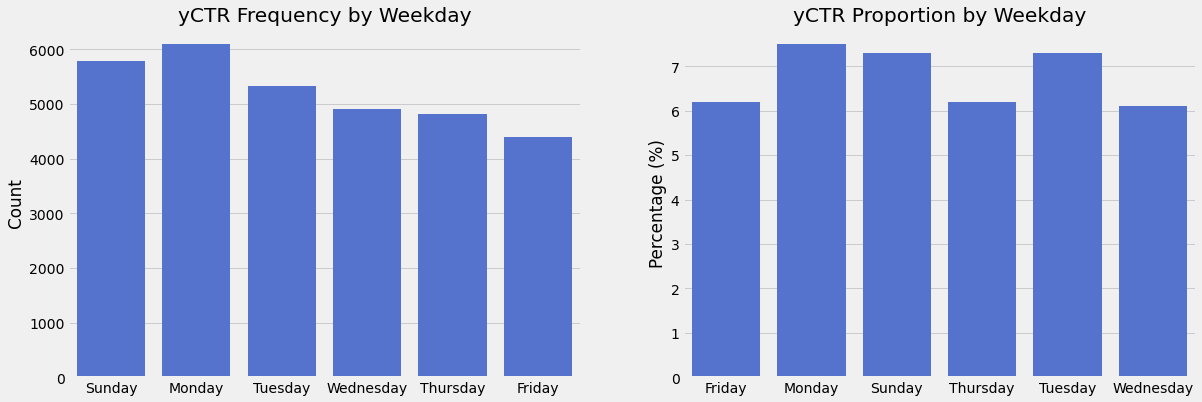

In [11]:
# Successful click through frequency by day of week
fig, axes = plt.subplots(1,2, figsize=(18,6))
sns.countplot(x='day_name', data=df[df.is_click == 1], ax=axes[0], color='royalblue')
axes[0].set(xlabel='', ylabel='Count', title='yCTR Frequency by Weekday')

# Successful click through proportion by data of week
sns.barplot(x=day_name_ratio.index, y='proportion', data=day_name_ratio, ax=axes[1], color='royalblue')
axes[1].set(xlabel='', ylabel='Percentage (%)', title='yCTR Proportion by Weekday')

plt.show()

In [12]:
hour_ratio = ctr_ratio(df, 'hour')
hour_ratio

is_click,0,1,proportion
hour,,,
0,2040,150,6.8
1,1476,119,7.5
2,1491,83,5.3
3,4686,311,6.2
4,9975,603,5.7
5,13989,1005,6.7
6,19200,1508,7.3
7,22544,1801,7.4
8,23868,1804,7.0


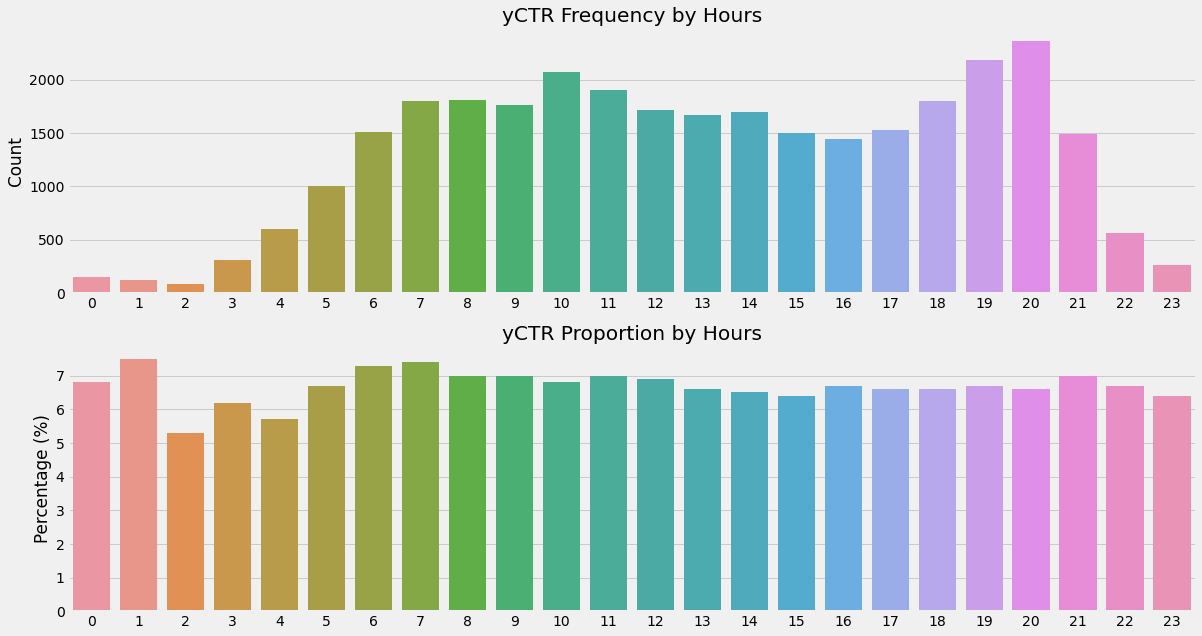

In [13]:
# Successful click through frequency by hour of day
fig, axes = plt.subplots(2, 1, figsize=(18,10))
sns.countplot(x='hour', data=df[df.is_click == 1], ax=axes[0])
axes[0].set(xlabel='', ylabel='Count', title='yCTR Frequency by Hours')

# Successful click through proportion by hour of day
sns.barplot(x=hour_ratio.index, y='proportion', data=hour_ratio, ax=axes[1])
axes[1].set(xlabel='', ylabel='Percentage (%)', title='yCTR Proportion by Hours')

plt.show()

### c. product

In [14]:
product = ctr_ratio(df, 'product')
product

is_click,0,1,proportion
product,,,
A,14438,953,6.2
B,21241,1238,5.5
C,152195,11306,6.9
D,38115,2949,7.2
E,19978,1474,6.9
F,6663,344,4.9
G,8979,435,4.6
H,101920,7654,7.0
I,59632,4079,6.4


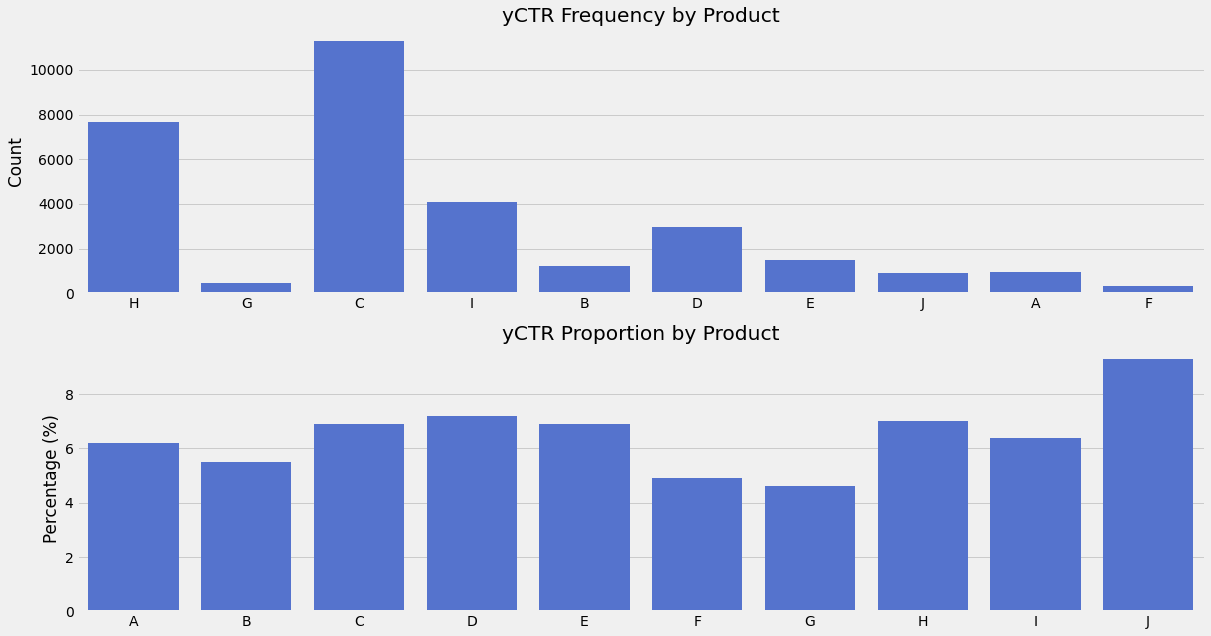

In [15]:
# Successful click through frequency by product
fig, axes = plt.subplots(2, 1, figsize=(18,10))
sns.countplot(x='product', data=df[df.is_click == 1], ax=axes[0], color='royalblue')
axes[0].set(xlabel='', ylabel='Count', title='yCTR Frequency by Product')

# Successful click through proportion by product
sns.barplot(x=product.index, y='proportion', data=product, ax=axes[1], color='royalblue')
axes[1].set(xlabel='', ylabel='Percentage (%)', title='yCTR Proportion by Product')

plt.show()

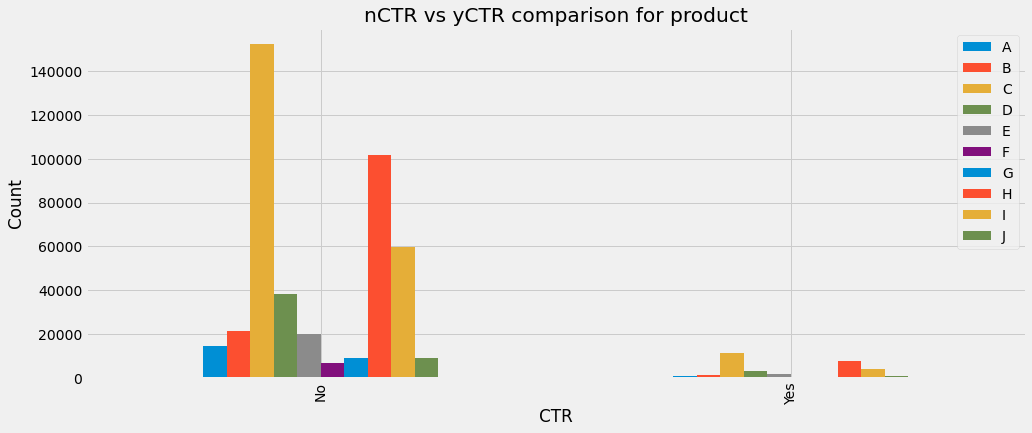

In [16]:
bar_chart(df, 'product')

### d. campaign_id

In [17]:
campaign = ctr_ratio(df, 'campaign_id')
campaign.to_csv('camp.csv')

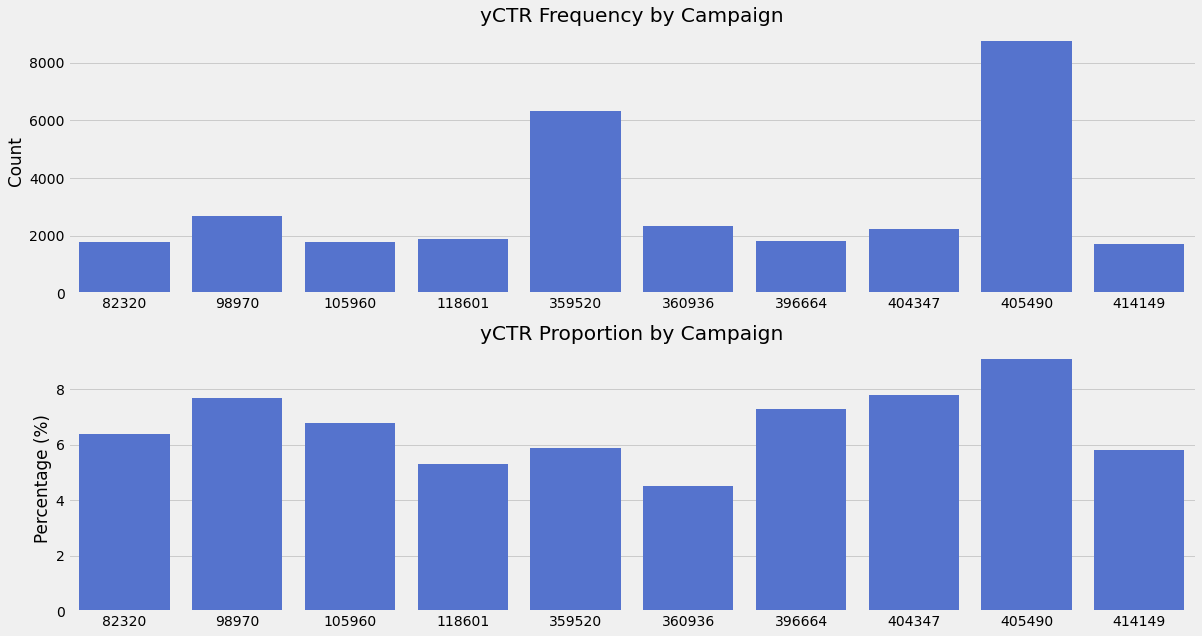

In [18]:
# Successful click through frequency by campaign
fig, axes = plt.subplots(2, 1, figsize=(18,10))
sns.countplot(x='campaign_id', data=df[df.is_click == 1], ax=axes[0], color='royalblue')
axes[0].set(xlabel='', ylabel='Count', title='yCTR Frequency by Campaign')

# Successful click through proportion by campaign
sns.barplot(x=campaign.index, y='proportion', data=campaign, ax=axes[1], color='royalblue')
axes[1].set(xlabel='', ylabel='Percentage (%)', title='yCTR Proportion by Campaign')

plt.show()

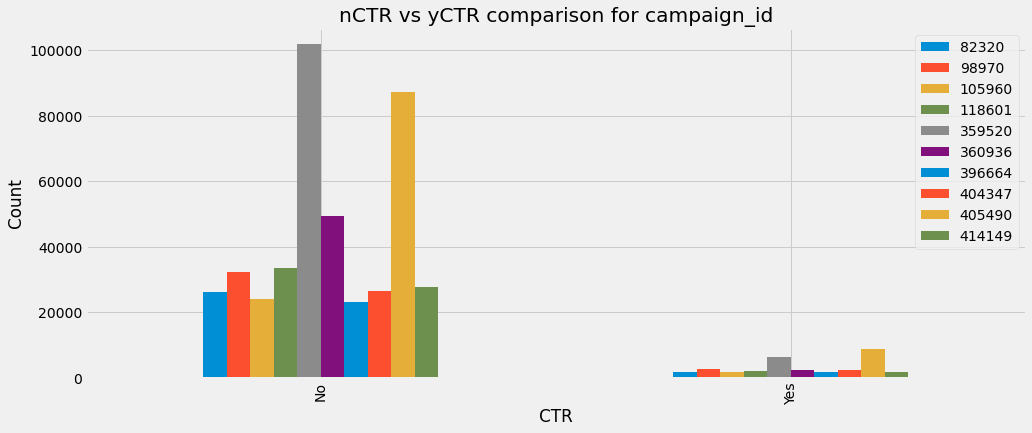

In [19]:
bar_chart(df, 'campaign_id')

### e. webpage_id

In [20]:
webpage = ctr_ratio(df, 'webpage_id')
webpage

is_click,0,1,proportion
webpage_id,,,
1734,26073,1776,6.4
6970,32371,2694,7.7
11085,24019,1762,6.8
13787,151357,8686,5.4
28529,33635,1896,5.3
45962,27604,1710,5.8
51181,23100,1809,7.3
53587,26591,2235,7.8
60305,87210,8763,9.1


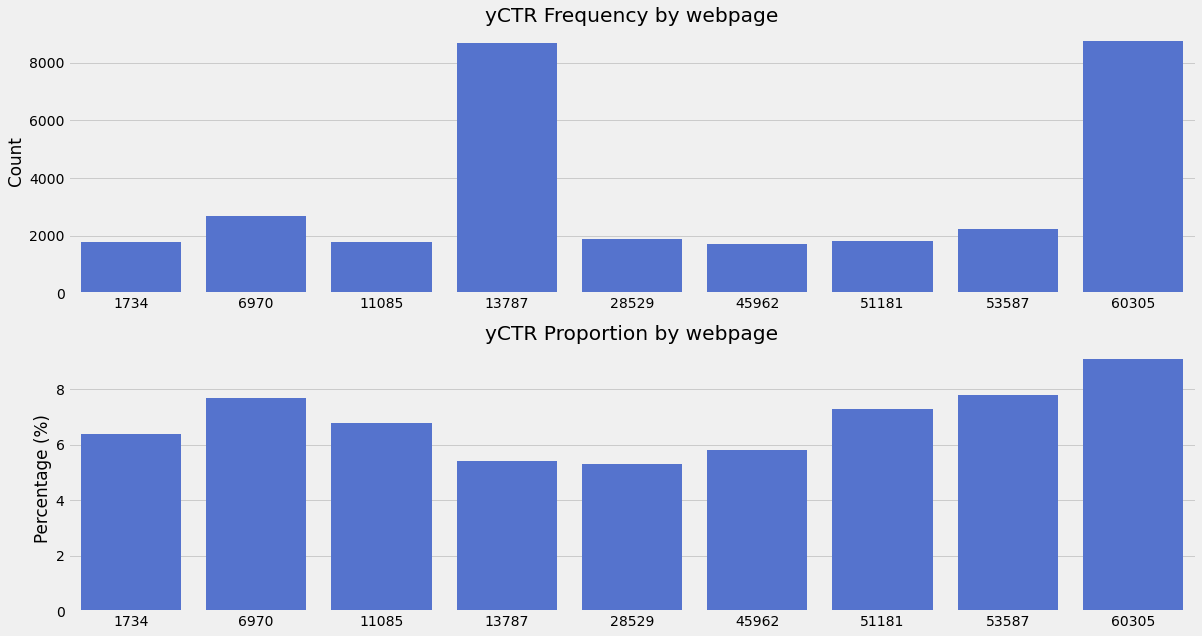

In [21]:
# Successful click through frequency by webpage
fig, axes = plt.subplots(2, 1, figsize=(18,10))
sns.countplot(x='webpage_id', data=df[df.is_click == 1], ax=axes[0], color='royalblue')
axes[0].set(xlabel='', ylabel='Count', title='yCTR Frequency by webpage')

# Successful click through proportion by webpage
sns.barplot(x=webpage.index, y='proportion', data=webpage, ax=axes[1], color='royalblue')
axes[1].set(xlabel='', ylabel='Percentage (%)', title='yCTR Proportion by webpage')

plt.show()

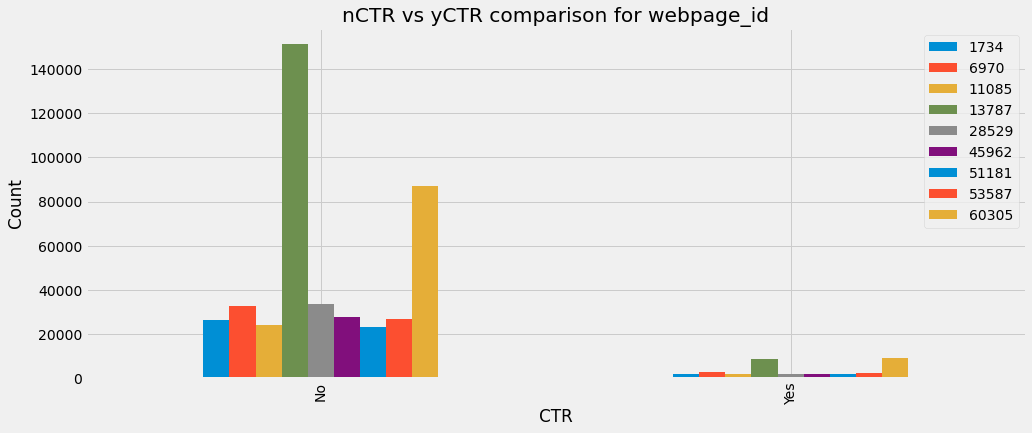

In [22]:
bar_chart(df, 'webpage_id')

### f. product_category_1

In [23]:
product_cat = ctr_ratio(df, 'product_category_1')
product_cat

is_click,0,1,proportion
product_category_1,,,
1,75335,5806,7.2
2,64913,4270,6.2
3,104306,9506,8.4
4,125435,7855,5.9
5,61971,3894,5.9


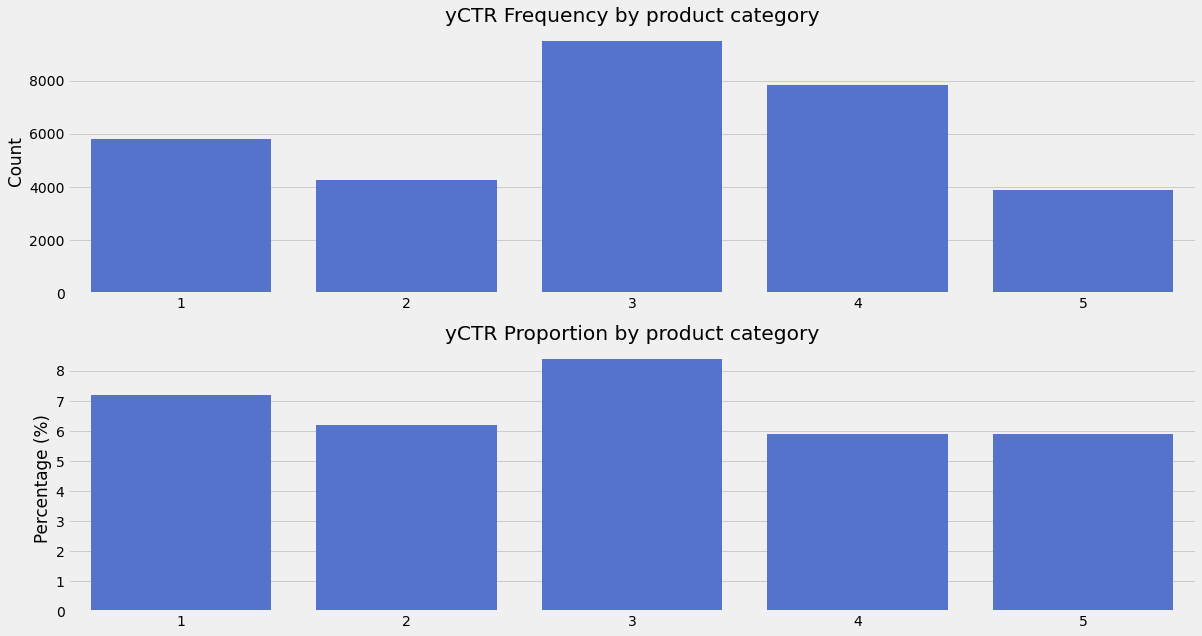

In [24]:
# Successful click through frequency by product category
fig, axes = plt.subplots(2, 1, figsize=(18,10))
sns.countplot(x='product_category_1', data=df[df.is_click == 1], ax=axes[0], color='royalblue')
axes[0].set(xlabel='', ylabel='Count', title='yCTR Frequency by product category')

# Successful click through proportion by product category
sns.barplot(x=product_cat.index, y='proportion', data=product_cat, ax=axes[1], color='royalblue')
axes[1].set(xlabel='', ylabel='Percentage (%)', title='yCTR Proportion by product category')

plt.show()

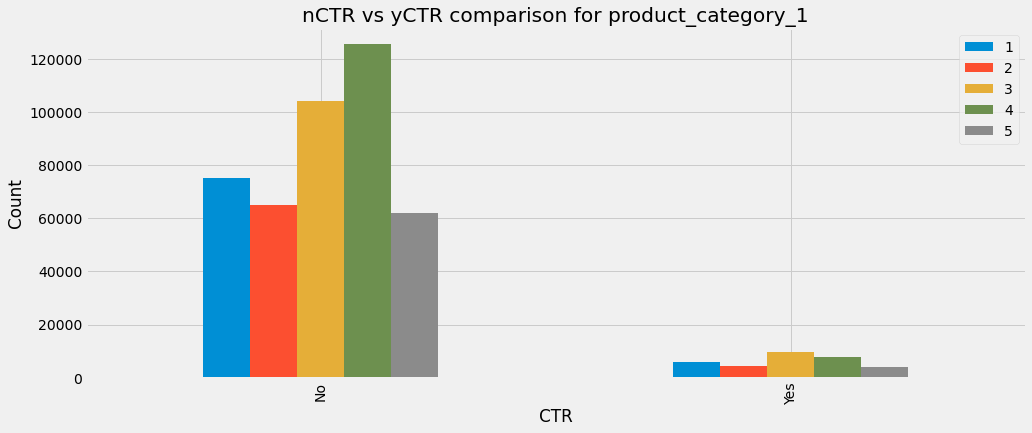

In [25]:
bar_chart(df, 'product_category_1')

### g. gender

In [26]:
gender = ctr_ratio(df, 'gender')
gender

is_click,0,1,proportion
gender,,,
Female,48269,3325,6.4
Male,366722,26732,6.8


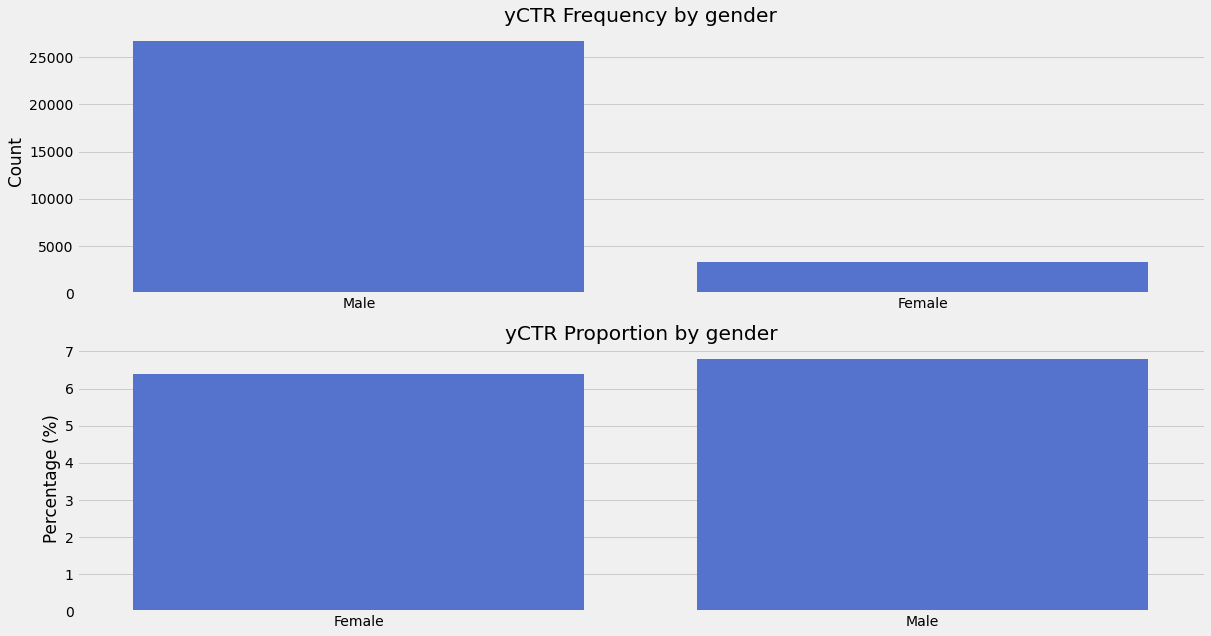

In [27]:
# Successful click through frequency by gender
fig, axes = plt.subplots(2, 1, figsize=(18,10))
sns.countplot(x='gender', data=df[df.is_click == 1], ax=axes[0], color='royalblue')
axes[0].set(xlabel='', ylabel='Count', title='yCTR Frequency by gender')

# Successful click through proportion by gender
sns.barplot(x=gender.index, y='proportion', data=gender, ax=axes[1], color='royalblue')
axes[1].set(xlabel='', ylabel='Percentage (%)', title='yCTR Proportion by gender')

plt.show()

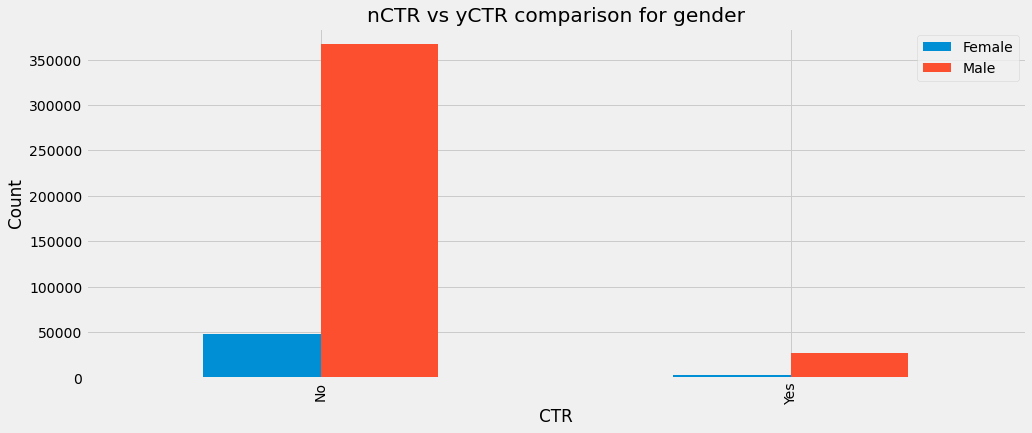

In [28]:
bar_chart(df, 'gender')

#### Hypothesis - Z-test

H0: There is no significance differences between male and female in term of yCTR<br>
H1: There is significance differences between male and female in term of yCTR<br>
Alpha = 0.05<br>
Sample size = 100

In [29]:
# Randomize samples 
n = 100
male = df[df.gender == 'Male'].sample(n, random_state=42)
female = df[df.gender == 'Female'].sample(n, random_state=42)

a = male['is_click'].to_numpy()
b = female['is_click'].to_numpy()

# z-test
z, pvalue = ztest(a, b, value=0)
print("t = " + str(z))
print("p = " + str(pvalue))

t = 0.0
p = 1.0


> We have failed to reject the null hypothesis. There is no significance differences between male and female in term of yCTR. Any differences are due to random chances.

### h. user_depth

In [30]:
user_depth = ctr_ratio(df, 'user_depth')
user_depth

is_click,0,1,proportion
user_depth,,,
1.0,11008,853,7.2
2.0,28398,1991,6.6
3.0,375585,27213,6.8


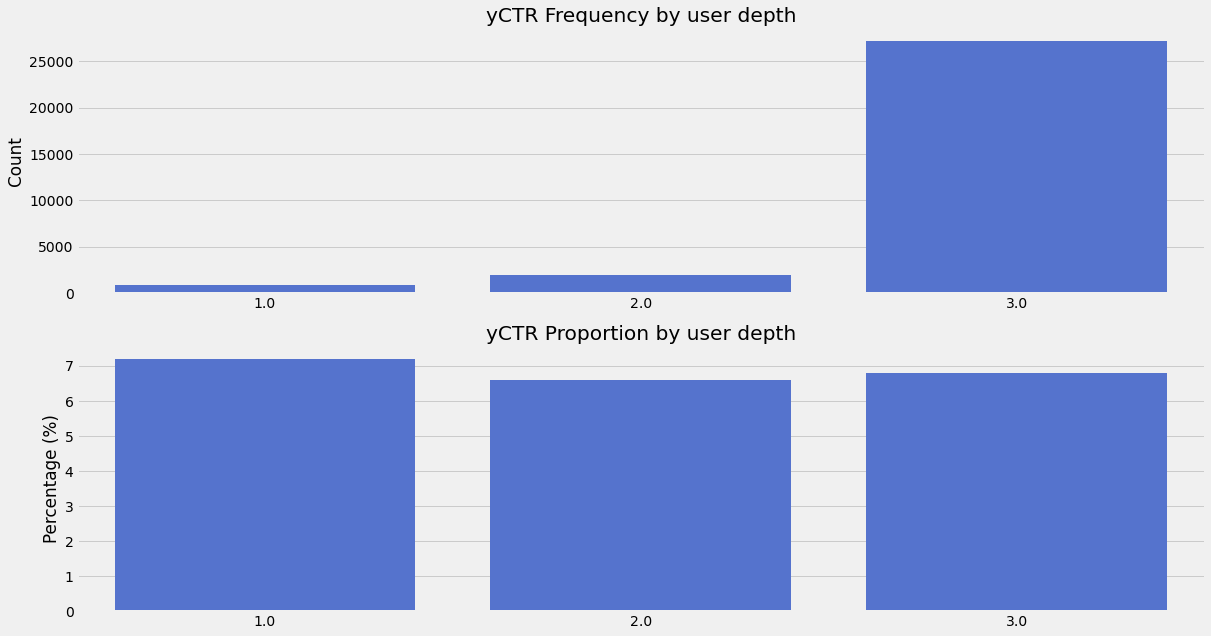

In [31]:
# Successful click through frequency by user depth
fig, axes = plt.subplots(2, 1, figsize=(18,10))
sns.countplot(x='user_depth', data=df[df.is_click == 1], ax=axes[0], color='royalblue')
axes[0].set(xlabel='', ylabel='Count', title='yCTR Frequency by user depth')

# Successful click through proportion by user depth
sns.barplot(x=user_depth.index, y='proportion', data=user_depth, ax=axes[1], color='royalblue')
axes[1].set(xlabel='', ylabel='Percentage (%)', title='yCTR Proportion by user depth')

plt.show()

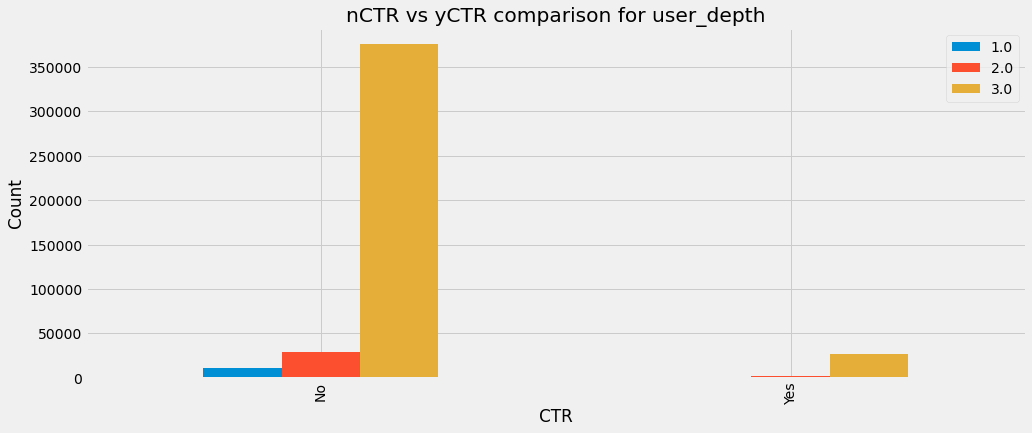

In [32]:
bar_chart(df, 'user_depth')

## 3. Preprocessing

In [33]:
features = ['campaign_id', 'gender', 'user_depth', 'day_name', 'hour', 'is_click']
data = df[features]
data.head()

,campaign_id,gender,user_depth,day_name,hour,is_click
0,359520,Female,3.0,Sunday,0,0
1,105960,Female,2.0,Sunday,0,0
2,359520,Female,2.0,Sunday,0,0
3,359520,Male,3.0,Sunday,0,0
4,405490,Male,3.0,Sunday,0,0


In [34]:
# NaN values accounted for 4% of data
data.isnull().sum() / data.shape[0] * 100

campaign_id    0.000000
gender         3.937698
user_depth     3.937698
day_name       0.000000
hour           0.000000
is_click       0.000000
dtype: float64

In [35]:
# Fill number out of their distribution
data.fillna(-999, inplace=True)

In [36]:
data['campaign_id'] = data.campaign_id.astype('O')
data['user_depth'] = data.user_depth.astype('int').astype('O')
data['hour'] = data.hour.astype('O')

In [37]:
hour_label = []
for i in data.hour:
    if i > 0 and i <= 6:
        hour_label.append('early')
    elif i > 6 and i <= 12:
        hour_label.append('morning')
    elif i > 12 and i <= 18:
        hour_label.append('afternoon')
    else:
        hour_label.append('night')

data['hour_label'] = hour_label

## 4. Base Model - CatBoost

In [38]:
X = data.drop('is_click', axis=1)
y =data.is_click

In [39]:
cat_features_indices = np.where(X.dtypes != float)[0]

In [40]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size=0.25, random_state=42, stratify=y_data)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)


(260601, 6) (260601,)
(86867, 6) (86867,)
(115823, 6) (115823,)


In [41]:
model = CatBoostClassifier(custom_loss=[metrics.Accuracy()],
                           random_seed=42,
                           logging_level='Silent',
                           auto_class_weights = 'Balanced')

In [43]:
model.fit(X_train, 
          y_train, 
          cat_features=cat_features_indices, 
          eval_set = (X_validation, y_validation), 
          logging_level='Silent')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [44]:
predictions = model.predict(X_test)
confusion_matrix(predictions, y_test)

array([[62549,  3703],
       [45441,  4130]], dtype=int64)

In [45]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72    107990
           1       0.08      0.53      0.14      7833

    accuracy                           0.58    115823
   macro avg       0.51      0.55      0.43    115823
weighted avg       0.89      0.58      0.68    115823



### Feature Importances

In [66]:
feature_importances = model.get_feature_importance()
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print(f"{name}: {score}")

campaign_id: 39.55715606832665
day_name: 20.985859755534392
hour: 13.930713628473093
hour_label: 10.556860404419401
gender: 7.699584398243621
user_depth: 7.269825745002866


### Oversampling-XGBoost

In [46]:
# def find_class_weight(y_train):
#     """Compute individual weight for each of the classes.
#     Output: array of weights with the same row as y_train
#     """
    
#     n_classes = len(np.unique(y_train))
#     class_weight = list(len(y_train) / (n_classes * np.bincount(y_train)))
#     # Instantiate empty array with the same size as y_train
#     weight_array = np.ones(y_train.shape[0], dtype='float')
    
#     for i, val in enumerate(y_train):
#         weight_array[i] = class_weight[val]
#     return weight_array

In [47]:
# xgb_model = xgb.XGBClassifier(n_estimators=500,  
#                               max_depth=3, 
#                               learning_rate=0.005, 
#                               objective= 'binary:logistic',
#                               n_jobs=-1, 
#                               random_state=42,
#                              )

# xgb_model.fit(X_train, y_train, sample_weight=find_class_weight(y_train))
# print(f'Accuracy of XGB classifier on training set: {xgb_model.score(X_train, y_train)}')
# print(f'Accuracy of XGB classifier on test set: {xgb_model.score(X_test, y_test)}')

### Hyperopt